In [24]:
# ----------------------------
# 1. IMPORT LIBRARIES
# ----------------------------

import pandas as pd
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.linear_model import LinearRegression
from datetime import timedelta
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import yfinance as yf
import pandas_market_calendars as mcal
import os

In [9]:
# ----------------------------
# 2. DATA COLLECTION FUNCTION
# ----------------------------

def load_nvda_data(file_path):
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"File '{file_path}' not found.")

    df = pd.read_csv(file_path, skiprows=3, header=None)
    df.columns = ['Datetime', 'Close', 'High', 'Low', 'Open', 'Volume']

    df['Datetime'] = pd.to_datetime(df['Datetime'], utc=True, errors='coerce')
    df = df.dropna(subset=['Datetime'])
    df.set_index('Datetime', inplace=True)
    df = df.sort_index()

    for col in ['Close', 'High', 'Low', 'Open', 'Volume']:
        df[col] = pd.to_numeric(df[col], errors='coerce')

    df = df.dropna()
    return df

In [10]:
# ----------------------------
# 3. FEATURE ENGINEERING
# ----------------------------

def add_moving_averages(df, windows=[20, 50]):
    for window in windows:
        df[f'{window}_MA'] = df['Close'].rolling(window=window).mean()
    return df

In [11]:
# ----------------------------
# 4. INTERACTIVE CANDLE CHART
# ----------------------------

def plot_and_save_chart(df, save_path="stock_analysis.html"):
    fig = make_subplots(
        rows=2, cols=1, shared_xaxes=True,
        vertical_spacing=0.03,
        subplot_titles=('Price & Trends', 'Volume'),
        row_width=[0.2, 0.7]
    )

    fig.add_trace(go.Candlestick(
        x=df.index,
        open=df['Open'],
        high=df['High'],
        low=df['Low'],
        close=df['Close'],
        name='NVDA'
    ), row=1, col=1)

    for ma in [c for c in df.columns if 'MA' in c]:
        fig.add_trace(go.Scatter(
            x=df.index,
            y=df[ma],
            line=dict(width=2),
            name=ma
        ), row=1, col=1)

    fig.add_trace(go.Bar(
        x=df.index,
        y=df['Volume'],
        name='Volume',
        marker_color='grey'
    ), row=2, col=1)

    fig.update_layout(
        title='NVDA Hourly Analysis',
        xaxis_rangeslider_visible=False,
        height=800,
        template='plotly_dark'
    )

    fig.write_html(save_path)
    fig.show()

In [12]:
# ----------------------------
# 5. TRADING-HOUR GENERATOR
# ----------------------------

def get_future_trading_hours(start_time, n_hours):
    nyse = mcal.get_calendar("NYSE")

    schedule = nyse.schedule(
        start_date=start_time.date(),
        end_date=(start_time + timedelta(days=14)).date()
    )

    trading_hours = []

    for _, row in schedule.iterrows():
        hours = pd.date_range(
            start=row["market_open"],
            end=row["market_close"],
            freq="1H",
            tz="UTC"
        )
        trading_hours.extend(hours)

    trading_hours = [t for t in trading_hours if t > start_time]
    return trading_hours[:n_hours]

In [13]:
# ----------------------------
# 6. PREDICTION FUNCTION
# ----------------------------

def get_predictions_all_columns(df, hours):
    features = ['Close', 'High', 'Low', 'Open', 'Volume']
    predictions = pd.DataFrame()

    df_p = df[features].copy()
    df_p['Index'] = np.arange(len(df_p))
    last_idx = df_p['Index'].iloc[-1]

    future_dates = get_future_trading_hours(df_p.index[-1], hours)
    predictions['Datetime'] = future_dates

    for col in features:
        model = LinearRegression()
        model.fit(df_p[['Index']], df_p[col])

        future_idx = np.arange(
            last_idx + 1,
            last_idx + 1 + len(future_dates)
        ).reshape(-1, 1)

        predictions[col] = model.predict(future_idx)

    return predictions

In [14]:
# ----------------------------
# 7. FORECAST PLOT
# ----------------------------

def plot_forecast_close(forecast_df):
    start = forecast_df['Datetime'].min()
    end = forecast_df['Datetime'].max() + timedelta(hours=1)

    real_df = yf.download(
        "NVDA",
        start=start,
        end=end,
        interval="1h",
        progress=False
    ).dropna()

    real_close = real_df['Close']
    common = forecast_df['Datetime'].isin(real_close.index)

    forecast_df = forecast_df[common]
    real_close = real_close.loc[forecast_df['Datetime']]

    plt.figure(figsize=(13, 6))

    plt.plot(
        real_close.index,
        real_close.values,
        label="Real Close (yfinance)",
        marker="o"
    )

    plt.plot(
        forecast_df['Datetime'],
        forecast_df['Close'],
        label="Predicted Close",
        linestyle="--",
        marker="x"
    )

    ax = plt.gca()
    ax.xaxis.set_major_locator(mdates.AutoDateLocator(minticks=6, maxticks=10))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))

    plt.xticks(rotation=45, ha="right")
    plt.xlabel("Datetime (Trading Hours)")
    plt.ylabel("Close Price")
    plt.title("NVDA Trading-Hour Close: Prediction vs Reality")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [15]:
file_path = 'NVDA_hourly_last_2_years.csv'

df = load_nvda_data(file_path)
df.head()

,Close,High,Low,Open,Volume
Datetime,,,,,
2023-03-03 14:30:00+00:00,23.341009,23.493000,23.130001,23.320000,10094629
2023-03-03 15:30:00+00:00,23.233999,23.410000,23.186001,23.344000,4601483
2023-03-03 16:30:00+00:00,23.375000,23.375999,23.138639,23.234650,3815060
2023-03-03 17:30:00+00:00,23.566990,23.607000,23.341980,23.377001,4450644
2023-03-03 18:30:00+00:00,23.697060,23.703999,23.539999,23.570000,3677958


In [16]:
df = add_moving_averages(df)
df.tail()

,Close,High,Low,Open,Volume,20_MA,50_MA
Datetime,,,,,,,
2026-01-29 16:30:00+00:00,189.544998,189.839996,187.690002,187.830002,13577127,189.563734,186.304643
2026-01-29 17:30:00+00:00,190.054993,190.690002,189.169998,189.539993,12734523,189.737734,186.505345
2026-01-29 18:30:00+00:00,190.360001,190.779999,189.705002,190.059998,9429560,189.933484,186.722145
2026-01-29 19:30:00+00:00,190.945007,191.449997,190.020004,190.360001,10769502,190.161234,186.952345
2026-01-29 20:30:00+00:00,192.429993,192.770004,190.860001,190.934998,12608605,190.336979,187.231045


In [27]:
plot_and_save_chart(df)

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

In [19]:
hours_to_predict = 24  # Change manually for testing

In [20]:
forecast_df = get_predictions_all_columns(df, hours_to_predict)
forecast_df

C:\Users\MSI\AppData\Local\Temp\ipykernel_16408\2184768423.py:16: FutureWarning:

'H' is deprecated and will be removed in a future version, please use 'h' instead.

c:\Users\MSI\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning:

X does not have valid feature names, but LinearRegression was fitted with feature names

c:\Users\MSI\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning:

X does not have valid feature names, but LinearRegression was fitted with feature names

c:\Users\MSI\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning:

X does not have valid feature names, but LinearRegression was fitted with feature names

c:\Users\MSI\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning:

X does not have valid feature names, but LinearRegression was fitted with feature names

c:

,Datetime,Close,High,Low,Open,Volume
0,2026-01-30 14:30:00+00:00,193.599958,194.632736,192.529262,193.618731,3.203356e+07
1,2026-01-30 15:30:00+00:00,193.634433,194.667380,192.563568,193.653212,3.203858e+07
2,2026-01-30 16:30:00+00:00,193.668908,194.702025,192.597874,193.687693,3.204360e+07
3,2026-01-30 17:30:00+00:00,193.703383,194.736669,192.632180,193.722173,3.204861e+07
4,2026-01-30 18:30:00+00:00,193.737858,194.771314,192.666486,193.756654,3.205363e+07
5,2026-01-30 19:30:00+00:00,193.772333,194.805958,192.700792,193.791135,3.205864e+07
6,2026-01-30 20:30:00+00:00,193.806809,194.840603,192.735098,193.825616,3.206366e+07
7,2026-02-02 14:30:00+00:00,193.841284,194.875247,192.769404,193.860096,3.206868e+07
8,2026-02-02 15:30:00+00:00,193.875759,194.909891,192.803710,193.894577,3.207369e+07
9,2026-02-02 16:30:00+00:00,193.910234,194.944536,192.838016,193.929058,3.207871e+07


C:\Users\MSI\AppData\Local\Temp\ipykernel_16408\1001241939.py:44: UserWarning:

AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 12.

C:\Users\MSI\AppData\Local\Temp\ipykernel_16408\1001241939.py:50: UserWarning:

AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 12.

C:\Users\MSI\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:170: UserWarning:

AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 12.



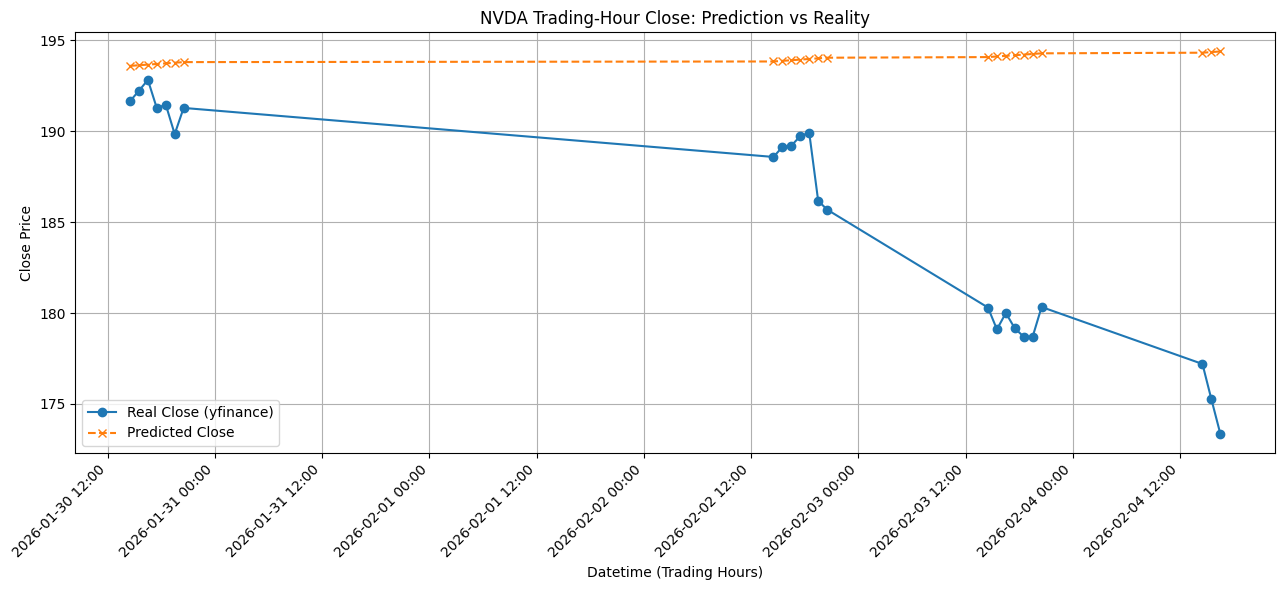

In [21]:
plot_forecast_close(forecast_df)